# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="./data/school.txt", data_format="vowpal_wabbit", target_folder="./data/school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

Создаем объект модели:

In [4]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T,
                       topic_names=["sbj"+str(i) for i in range(T)],
                       class_ids={"text":1},
                       seed=-1,
                       num_document_passes=1,
                       cache_theta=True,
                       )
# число после названия модальностей - это их веса

In [5]:
#model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
#                                               use_unigram_document_model=False,
#                                               dictionary_name='dictionary'))

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.initialize(dictionary=dictionary)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [8]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

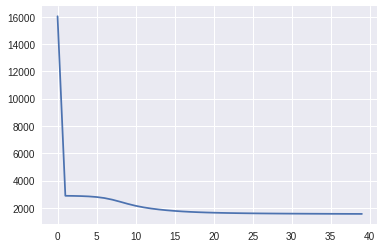

In [9]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)
plt.show()

Выведем топы слов:

In [10]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print(word, end=" ")
    print()

sbj0:  человек быть также для как право являться это так они ребенок мочь который иметь время 
sbj1:  что его свой который образ она этот это они герой быть однако главный такой весь 
sbj2:  слово сила предложение например или который как если это когда что такой один часть мочь 
sbj3:  тело что это энергия вода этот ядро как масса земля такой движение мочь который при 
sbj4:  что который это весь этот пушкин свой поэт для быть стихотворение русский год как становиться 
sbj5:  x быть a число b функция при получать этот уравнение если точка два следующий корень 
sbj6:  человек жизнь свой его произведение герой литература который как русский что мир рассказ автор писатель 
sbj7:  который общество развитие человек государство социальный политический век себя новый культура процесс государственный власть отношение 
sbj8:  страна территория государство население этот северный часть также природный мир африка являться сша производство регион 
sbj9:  быть год война который становиться первый 

Давайте посмотрим также на разреженность матриц:

In [11]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.6426175832748413
0.0008403361425735056


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [12]:
SSR = artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100)
SSR.dictionary_name = "dictionary"
model_artm.regularizers.add(SSR)

In [13]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [14]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end=" ")
    for word in model_artm.score_tracker["top_words"].last_tokens[topic_name]:
        print(word, end=" ")
    print()

sbj0:  как для являться время так мочь также иметь другой себя каждый отношение основной право ребенок 
sbj1:  что они его она самый главный однако образ даже 
sbj2:  один или сила если слово например пример предложение когда форма случай работа предмет речь 
sbj3:  такой это этот что тело земля происходить энергия вода наш количество ядро масса движение атом 
sbj4:  весь это этот который пушкин поэт стихотворение 
sbj5:  при x a два число вид можно b функция получать равный уравнение точка любой корень 
sbj6:  человек свой жизнь герой русский произведение мир литература автор литературный писатель рассказ чувство 
sbj7:  который общество век новый себя развитие социальный политический процесс власть экономический культура государственный общественный 
sbj8:  государство страна часть территория население производство северный природный африка сша регион хозяйство 
sbj9:  быть год становиться первый россия период после война начинать народ город смочь политика военный империя 


Попробуем менять коэффициент регуляризации:

In [15]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9991055130958557
0.06932773441076279


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [16]:
model_artm.save("./model/my_model")

In [17]:
model_artm.load("./model/my_model")

Можно попросить матрицы в чистом виде:

In [18]:
phi = model_artm.get_phi()

In [19]:
phi[(phi > 0).any(axis=1)]

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
движение,0.0,0.000000,0.000000,0.011944,0.0,0.000000,0.0,0.000000,0.0,0.0
его,0.0,0.162289,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
можно,0.0,0.000000,0.000000,0.000000,0.0,0.060295,0.0,0.000000,0.0,0.0
магнитный,0.0,0.000000,0.000000,0.000000,0.0,0.000962,0.0,0.000000,0.0,0.0
энергия,0.0,0.000000,0.000000,0.034383,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
количество,0.0,0.000000,0.000000,0.021716,0.0,0.000000,0.0,0.000000,0.0,0.0
работа,0.0,0.000000,0.020807,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
развитие,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.051293,0.0,0.0
происходить,0.0,0.000000,0.000000,0.045603,0.0,0.000000,0.0,0.000000,0.0,0.0


Матрица вероятностей тем в документах.

In [20]:
theta = model_artm.get_theta()
theta

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
sbj0,0.180556,0.108237,0.177380,0.088383,0.091667,0.494281,0.040230,0.165468,0.161290,0.100000,...,0.105602,0.119048,0.395581,0.204980,0.059406,0.318333,0.126700,0.196970,0.175258,0.139513
sbj1,0.027778,0.048078,0.162366,0.071630,0.050000,0.073090,0.004182,0.121658,0.091658,0.048966,...,0.043103,0.119048,0.043832,0.090924,0.046808,0.050000,0.076074,0.045455,0.189336,0.033708
sbj2,0.027778,0.011494,0.071429,0.030303,0.016667,0.058824,0.040230,0.028777,0.185484,0.115385,...,0.060345,0.047619,0.060241,0.068966,0.029703,0.090000,0.030612,0.045455,0.041237,0.101124
sbj3,0.057607,0.045202,0.188460,0.004127,0.075272,0.033308,0.009194,0.039569,0.233451,0.044726,...,0.071231,0.303275,0.050389,0.047962,0.045222,0.085255,0.042193,0.404135,0.092913,0.030396
sbj4,0.068664,0.062215,0.090219,0.003307,0.066100,0.029613,0.009613,0.060883,0.059204,0.038756,...,0.025479,0.082875,0.022103,0.075538,0.025526,0.090025,0.064112,0.097251,0.088885,0.030689
sbj5,0.013889,0.022989,0.057143,0.045455,0.025000,0.019608,0.867816,0.021583,0.185484,0.638462,...,0.068966,0.142857,0.096386,0.022989,0.009901,0.050000,0.020408,0.090909,0.030928,0.573034
sbj6,0.013889,0.034483,0.028571,0.015152,0.008333,0.039216,0.011494,0.280576,0.000000,0.000000,...,0.120690,0.023810,0.096386,0.206897,0.049505,0.040000,0.091837,0.000000,0.247423,0.033708
sbj7,0.137619,0.196038,0.053003,0.044674,0.258628,0.222649,0.000000,0.080049,0.018912,0.006013,...,0.461481,0.018612,0.078456,0.051861,0.159672,0.206387,0.099084,0.074372,0.020619,0.024121
sbj8,0.055556,0.172414,0.014286,0.045455,0.183333,0.019608,0.005747,0.014388,0.008065,0.000000,...,0.017241,0.119048,0.108434,0.045977,0.198020,0.040000,0.061224,0.030303,0.000000,0.000000
sbj9,0.416667,0.298851,0.157143,0.651515,0.225000,0.009804,0.011494,0.187050,0.056452,0.007692,...,0.025862,0.023810,0.048193,0.183908,0.376238,0.030000,0.387755,0.015152,0.113402,0.033708


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [21]:
theta_test = model_artm.transform(batch_vectorizer)